In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import xgboost as xgb
from pylab import rcParams



In [2]:
#TRAIN/VALIDATION/TEST SPLIT
#VALIDATION
VALID_SIZE = 0.20 # simple validation using train_test_split
TEST_SIZE = 0.20 # test size using_train_test_split

#CROSS-VALIDATION
NUMBER_KFOLDS = 5 #number of KFolds for cross-validation



RANDOM_STATE = 2018

RFC_METRIC = 'gini'  #metric used for RandomForrestClassifier
NUM_ESTIMATORS = 100 #number of estimators used for RandomForrestClassifier
NO_JOBS = 4 #number of parallel jobs used for RandomForrestClassifier

MAX_ROUNDS = 1000 #lgb iterations
EARLY_STOP = 50 #lgb early stop 
OPT_ROUNDS = 1000  #To be adjusted based on best validation rounds
VERBOSE_EVAL = 50 #Print out metric result

In [3]:
df = pd.read_csv("creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [5]:
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

/var/folders/l3/4gt1fnzn0tb_w454ztn4pn_w0000gn/T/ipykernel_1509/660306891.py:2: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(df['Class'], sort=True)


Text(0, 0.5, 'Frequency')

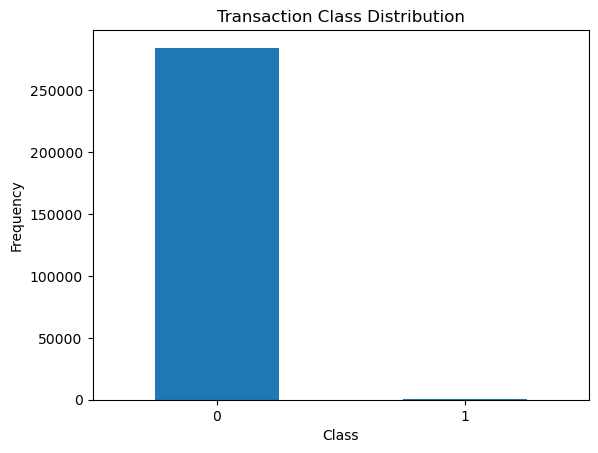

In [11]:
#EDA
count_classes = pd.value_counts(df['Class'], sort=True)
count_classes.plot(kind = 'bar', rot=0)

plt.title("Transaction Class Distribution")



plt.xlabel("Class")

plt.ylabel("Frequency")

In [13]:
#Get the Fraud and the normal dataset 

fraud = df[df['Class']==1]
normal = df[df['Class']==0]

print(fraud.shape,normal.shape)

(492, 31) (284315, 31)


In [14]:
#comparing the two transaction classes
fraud.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [15]:
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

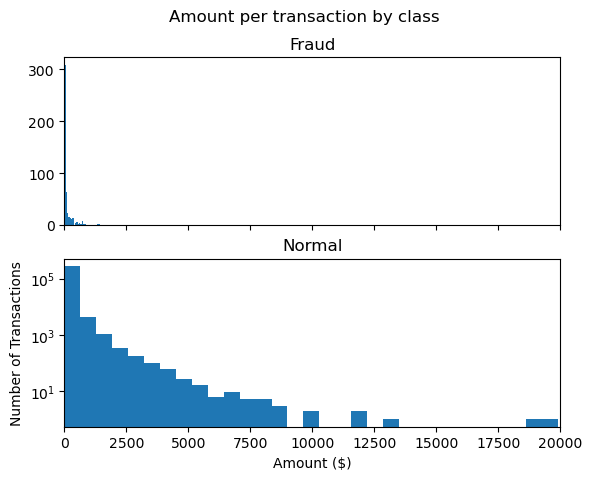

In [16]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')
bins = 40
ax1.hist(fraud.Amount, bins = bins)
ax1.set_title('Fraud')
ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

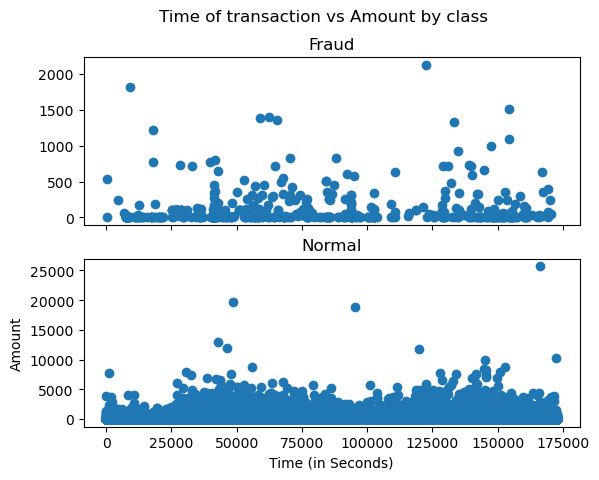

In [17]:
# We Will check Do fraudulent transactions occur more often during certain time frame ? Let us find out with a visual representation.

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')
ax1.scatter(fraud.Time, fraud.Amount)
ax1.set_title('Fraud')
ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')
plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

In [18]:
# Taking a fraction of sample data

df1= df.sample(frac = 0.1,random_state=1)
print(df.shape)
print(df1.shape)

(284807, 31)
(28481, 31)


In [19]:
#Determine the number of fraud and valid transactions in the dataset

Fraud = df1[df1['Class']==1]

Valid = df1[df1['Class']==0]

outlier_fraction = len(Fraud)/float(len(Valid))

print(outlier_fraction)

print("Fraud Cases : {}".format(len(Fraud)))

print("Valid Cases : {}".format(len(Valid)))

0.0017234102419808666
Fraud Cases : 49
Valid Cases : 28432


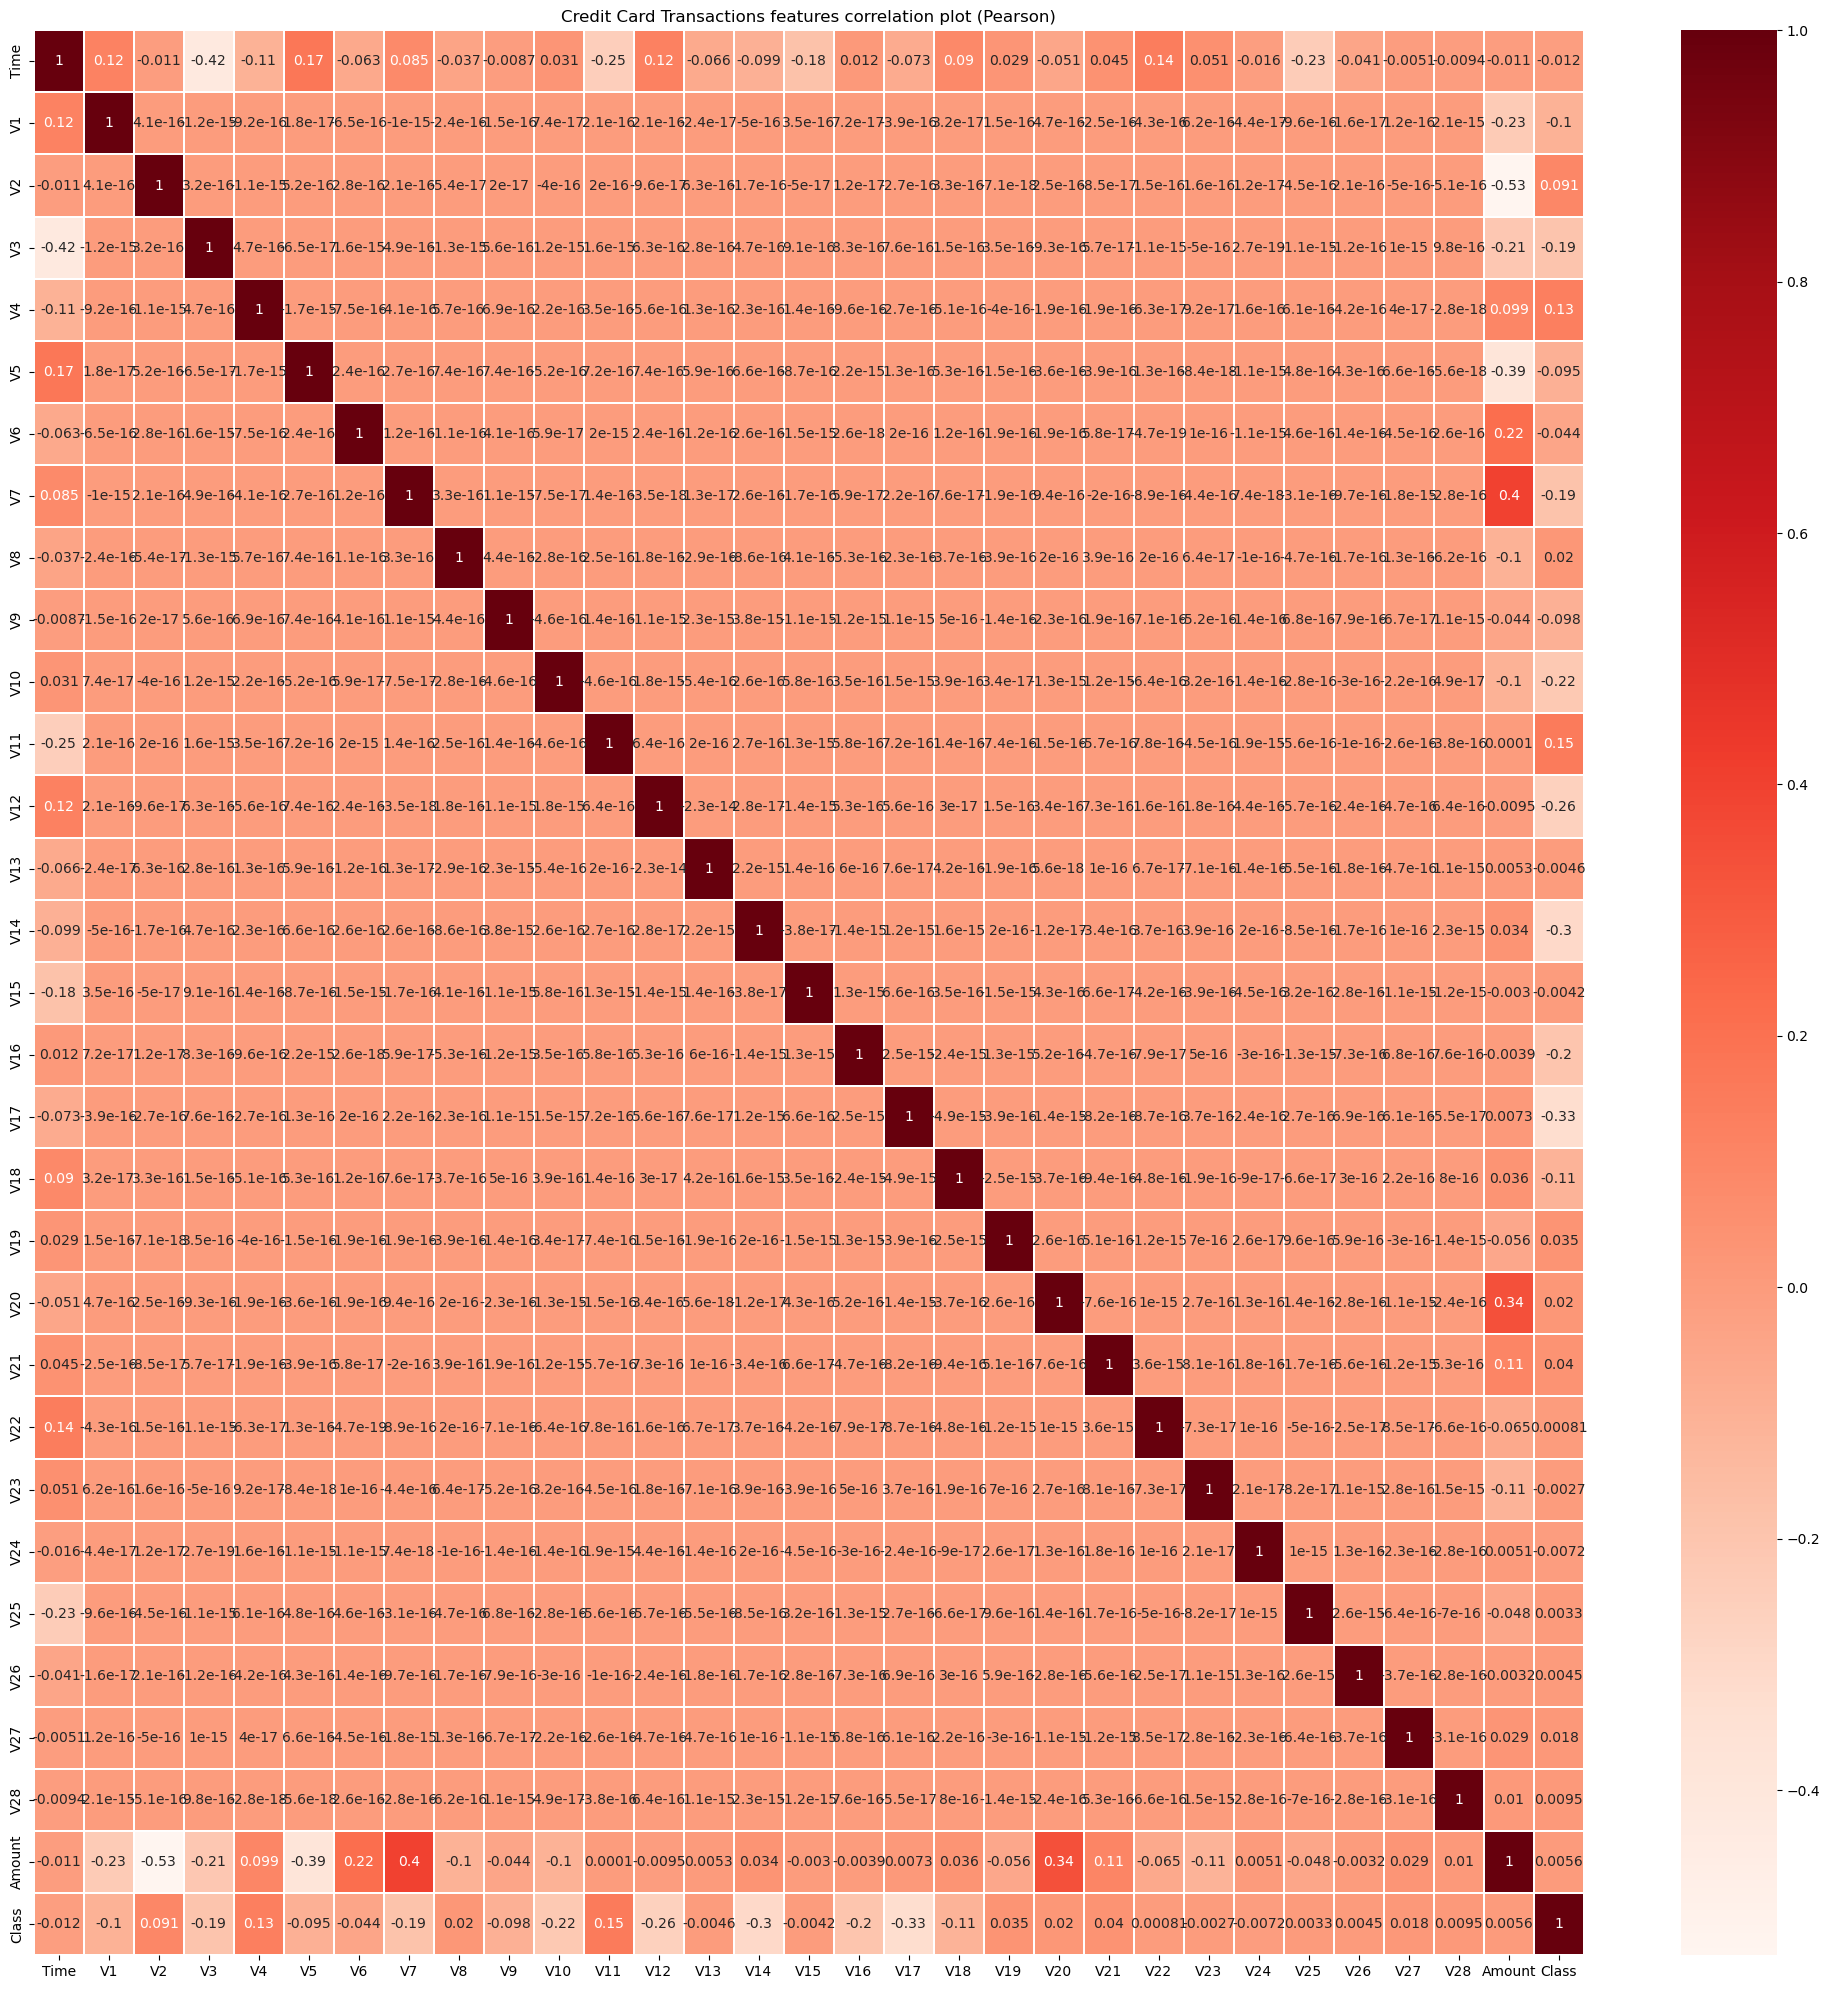

In [20]:
# Correlation matrix
corrmat = df1.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(25,25))
plt.title('Credit Card Transactions features correlation plot (Pearson)')
#plot heat map
g=sns.heatmap(df[top_corr_features].corr(),annot=True,linewidths=.1,cmap="Reds")

In [21]:
# Model Development¶

In [22]:
target = 'Class'
predictors = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',\
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',\
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',\
       'Amount']

In [23]:
train_df, test_df = train_test_split(df, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True )
train_df, valid_df = train_test_split(train_df, test_size=VALID_SIZE, random_state=RANDOM_STATE, shuffle=True )

In [24]:
#Random Forest

In [25]:
clf = RandomForestClassifier(n_jobs=NO_JOBS, 
                             random_state=RANDOM_STATE,
                             criterion=RFC_METRIC,
                             n_estimators=NUM_ESTIMATORS,
                             verbose=False)

In [26]:
clf.fit(train_df[predictors], train_df[target].values)

RandomForestClassifier(n_jobs=4, random_state=2018, verbose=False)

In [27]:
preds = clf.predict(valid_df[predictors])

In [28]:
#Feature importance¶

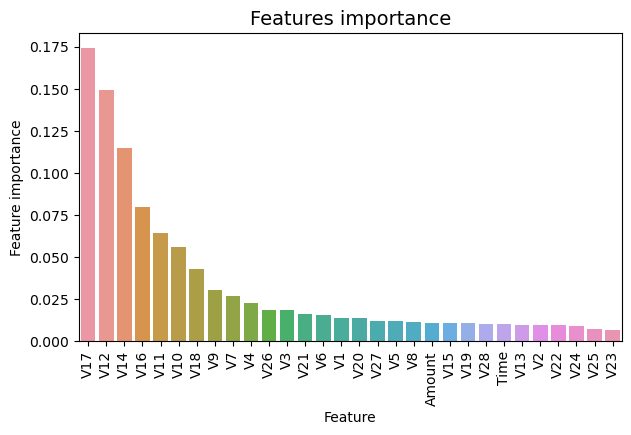

In [29]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()  

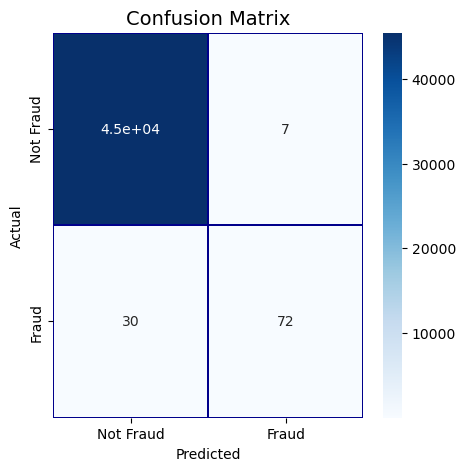

In [30]:
cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [31]:
#XGBoost

In [32]:
dtrain = xgb.DMatrix(train_df[predictors], train_df[target].values)
dvalid = xgb.DMatrix(valid_df[predictors], valid_df[target].values)
dtest = xgb.DMatrix(test_df[predictors], test_df[target].values)

watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

params = {}
params['objective'] = 'binary:logistic'
params['eta'] = 0.039
params['silent'] = True
params['max_depth'] = 2
params['subsample'] = 0.8
params['colsample_bytree'] = 0.9
params['eval_metric'] = 'auc'
params['random_state'] = RANDOM_STATE

In [33]:
model = xgb.train(params, 
                dtrain, 
                MAX_ROUNDS, 
                watchlist, 
                early_stopping_rounds=EARLY_STOP, 
                maximize=True, 
                verbose_eval=VERBOSE_EVAL)

[0]	train-auc:0.94070	valid-auc:0.88630


/Users/jagatheespandi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
/Users/jagatheespandi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:18:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-auc:0.94045	valid-auc:0.89040
[100]	train-auc:0.97428	valid-auc:0.96302
[150]	train-auc:0.98695	valid-auc:0.98056
[200]	train-auc:0.99276	valid-auc:0.98504
[250]	train-auc:0.99514	valid-auc:0.98432
[266]	train-auc:0.99569	valid-auc:0.98382


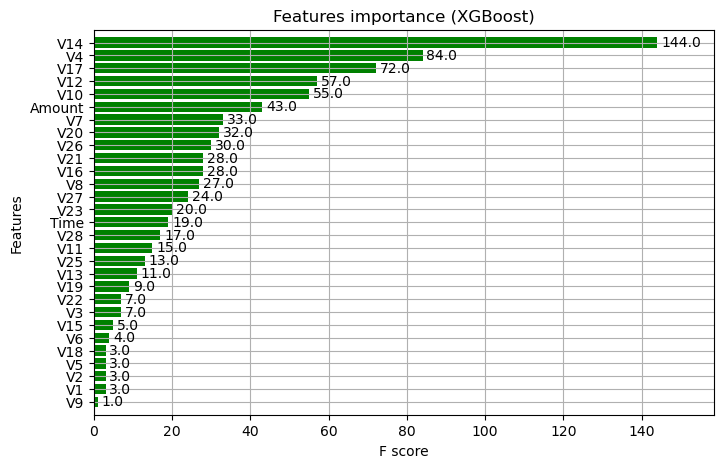

In [34]:
fig, (ax) = plt.subplots(ncols=1, figsize=(8,5))
xgb.plot_importance(model, height=0.8, title="Features importance (XGBoost)", ax=ax, color="green") 
plt.show()

In [35]:
preds = model.predict(dtest)

In [36]:
roc_auc_score(test_df[target].values, preds)


0.9806594034680455

In [37]:
#Training and validation using cross-validation

In [38]:
kf = KFold(n_splits = NUMBER_KFOLDS, random_state = RANDOM_STATE, shuffle = True)

# Create arrays and dataframes to store results
oof_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
feature_importance_df = pd.DataFrame()
n_fold = 0
for train_idx, valid_idx in kf.split(train_df):
    train_x, train_y = train_df[predictors].iloc[train_idx],train_df[target].iloc[train_idx]
    valid_x, valid_y = train_df[predictors].iloc[valid_idx],train_df[target].iloc[valid_idx]

In [39]:
# Initialize KFold
kf = KFold(n_splits=NUMBER_KFOLDS, random_state=RANDOM_STATE, shuffle=True)

# Create arrays to store results
oof_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])


In [40]:
# Loop through folds
for fold, (train_idx, valid_idx) in enumerate(kf.split(train_df)):
    train_x, train_y = train_df[predictors].iloc[train_idx], train_df[target].iloc[train_idx]
    valid_x, valid_y = train_df[predictors].iloc[valid_idx], train_df[target].iloc[valid_idx]

In [41]:
# Prepare the train and validation datasets
dtrain = xgb.DMatrix(train_x, label=train_y)
dvalid = xgb.DMatrix(valid_x, label=valid_y)


In [42]:
# Set xgboost parameters
params = {
        'objective': 'binary:logistic',
        'eta': 0.039,
        'max_depth': 2,
        'subsample': 0.8,
        'colsample_bytree': 0.9,
        'eval_metric': 'auc',
        'random_state': RANDOM_STATE
    }


In [43]:
# Train the model
model = xgb.train(params, 
                      dtrain, 
                      MAX_ROUNDS, 
                      [(dtrain, 'train'), (dvalid, 'valid')], 
                      early_stopping_rounds=EARLY_STOP, 
                      maximize=True, 
                      verbose_eval=VERBOSE_EVAL)

[0]	train-auc:0.93476	valid-auc:0.96503


/Users/jagatheespandi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[50]	train-auc:0.93435	valid-auc:0.96479
[54]	train-auc:0.93435	valid-auc:0.96479


In [44]:
# Make predictions on validation set
valid_preds = model.predict(dvalid)

In [45]:
# Store out-of-fold predictions
oof_preds[valid_idx] = valid_preds

In [46]:
# Make predictions on test set and average them over folds
test_preds += model.predict(xgb.DMatrix(test_df[predictors])) / kf.n_splits

In [47]:
# Calculate and print AUC score for each fold
auc_score = roc_auc_score(valid_y, valid_preds)
print(f"Fold {fold + 1} AUC: {auc_score}")

Fold 5 AUC: 0.9647863171746818


In [48]:
# Calculate full AUC score
full_auc_score = roc_auc_score(train_df[target], oof_preds)
print(f"Full AUC score: {full_auc_score}")

Full AUC score: 0.5185919000211081


In [49]:
#Random Forest accuracy report

In [50]:
# Initialize and train the RandomForestClassifier
clf = RandomForestClassifier(n_jobs=NO_JOBS, 
                             random_state=RANDOM_STATE,
                             criterion=RFC_METRIC,
                             n_estimators=NUM_ESTIMATORS,
                             verbose=False)
clf.fit(train_df[predictors], train_df[target].values)

# Predictions
preds = clf.predict(valid_df[predictors])

# Accuracy Score
accuracy = accuracy_score(valid_df[target].values, preds)

# Classification Report
report = classification_report(valid_df[target].values, preds)

# Confusion Matrix
cm = confusion_matrix(valid_df[target].values, preds)

# Calculate ROC-AUC score
roc_auc = roc_auc_score(valid_df[target].values, preds)

# Print the accuracy report
print("Model Name: RandomForestClassifier\n")
print("Accuracy Score:")
print(accuracy)
print("\nClassification Report:")
print(report)
print("\nConfusion Matrix:")
print(cm)
print("\nROC-AUC Score:")
print(roc_auc)

Model Name: RandomForestClassifier

Accuracy Score:
0.999188044503939

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45467
           1       0.91      0.71      0.80       102

    accuracy                           1.00     45569
   macro avg       0.96      0.85      0.90     45569
weighted avg       1.00      1.00      1.00     45569


Confusion Matrix:
[[45460     7]
 [   30    72]]

ROC-AUC Score:
0.8528641975628091


In [51]:
# XGBoost accuracy report¶

In [52]:
# Prepare the train and test datasets
dtrain = xgb.DMatrix(train_df[predictors], train_df[target].values)
dvalid = xgb.DMatrix(valid_df[predictors], valid_df[target].values)
dtest = xgb.DMatrix(test_df[predictors], test_df[target].values)

# Set xgboost parameters
params = {
    'objective': 'binary:logistic',
    'eta': 0.039,
    'silent': True,
    'max_depth': 2,
    'subsample': 0.8,
    'colsample_bytree': 0.9,
    'eval_metric': 'auc',
    'random_state': RANDOM_STATE
}

# Watchlist
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# Train the model
model = xgb.train(params, 
                  dtrain, 
                  MAX_ROUNDS, 
                  watchlist, 
                  early_stopping_rounds=EARLY_STOP, 
                  maximize=True, 
                  verbose_eval=VERBOSE_EVAL)

# Predict test set
preds = model.predict(dtest)

# Accuracy Score
accuracy = accuracy_score(test_df[target].values, preds.round())

# Classification Report
report = classification_report(test_df[target].values, preds.round())

# Confusion Matrix
cm = confusion_matrix(test_df[target].values, preds.round())

# Calculate ROC-AUC score
roc_auc = roc_auc_score(test_df[target].values, preds)

# Print the accuracy report
print("Model Name: XGBoost\n")
print("Accuracy Score:")
print(accuracy)
print("\nClassification Report:")
print(report)
print("\nConfusion Matrix:")
print(cm)
print("\nROC-AUC Score:")
print(roc_auc)

[0]	train-auc:0.94070	valid-auc:0.88630


/Users/jagatheespandi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
/Users/jagatheespandi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:24:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-auc:0.94045	valid-auc:0.89040
[100]	train-auc:0.97428	valid-auc:0.96302
[150]	train-auc:0.98695	valid-auc:0.98056
[200]	train-auc:0.99276	valid-auc:0.98504
[250]	train-auc:0.99514	valid-auc:0.98432
[266]	train-auc:0.99569	valid-auc:0.98382
Model Name: XGBoost

Accuracy Score:
0.9994557775359011

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56862
           1       0.94      0.74      0.83       100

    accuracy                           1.00     56962
   macro avg       0.97      0.87      0.91     56962
weighted avg       1.00      1.00      1.00     56962


Confusion Matrix:
[[56857     5]
 [   26    74]]

ROC-AUC Score:
0.9806594034680455
